In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d7536e72d979eef9a8ff7676f1e4ebd36ca13cb9298f6e7260ece2ea13ec8378
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import scipy.stats as stats

import pandas as pd
import numpy as np
from google.colab import files

import ta
from ta import add_all_ta_features
from ta.utils import dropna

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree



uploaded = files.upload()

In [ ]:
### UTILITY FUNCTIONS

# read stocks data from CSVs
def getStockData(path):

    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)

    return df


# standardize values in array
def standardize_data(ds):
    sc = StandardScaler()
    sc.fit(ds)
    res = sc.transform(ds)

    return res


# Get Next-Day Close
def getNextDayClose(df):

  close = df['Close'][1:len(df['Close'])]

  return close


# Get Standard Deviation
# using 30-day window
def getStdDev(df, window=30):
    res = df[['Date', 'Close']]
    res.insert(0, 'stdDev', df['Close'].rolling(window).std())

    return res

In [ ]:
### INDICATOR FUNCTIONS

# Get Stochastic Oscillator
def getSTO(df):

  res_raw = (
       ta.momentum.StochasticOscillator(
          high = df['High'],
          low = df['Low'],
          close = df['Close']
        )
      .stoch()
      .values.reshape(-1,1)
  )

  res = standardize_data(res_raw)

  return res


# Get Relative Strength Index
def getRSI(df):

  res_raw = (
       ta.momentum.RSIIndicator(
          df['Close'],
        )
      .rsi()
      .values.reshape(-1,1)
  )

  res = standardize_data(res_raw)

  return res


# Get MACD
def getMAC(df):

  res_raw = (
       ta.trend.MACD(
          df['Close'],
        )
      .macd()
      .values.reshape(-1,1)
  )

  res = standardize_data(res_raw)

  return res


# Get Aroon Indicator
def getARI(df):

  res_raw = (
       ta.trend.AroonIndicator(
          high = df['High'],
          low = df['Low']
        )
      .aroon_indicator()
      .values.reshape(-1,1)
  )

  res = standardize_data(res_raw)

  return res


# Get Average Directional Index
def getADX(df):

  res_raw = (
       ta.trend.ADXIndicator(
          df['High'],
          df['Low'],
          df['Close']
        )
      .adx()
      .values.reshape(-1,1)
  )

  res = standardize_data(res_raw)

  return res


# Get Accumulation/Distribution Index
def getADI(df):

  res_raw = (
       ta.volume.acc_dist_index(
          df['High'],
          df['Low'],
          df['Close'],
          df['Volume'],
        )
      .values.reshape(-1,1)
  )

  res = standardize_data(res_raw)

  return res


# Get On-Balance Volume Indicator
def getOBV(df):

  res_raw = (
      ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume'])
      .on_balance_volume()
      .values.reshape(-1,1)
  )

  res = standardize_data(res_raw)

  return res

In [ ]:
### MAIN

# Files stored in https://drive.google.com/drive/folders/1m8i0sSAy6VHuo-p9Qux_BrxKeT5iKien?usp=drive_link
stocks = ['F_2016.csv',
          'GM_2016.csv',
          'HMC_2016.csv',
          'MBGAF_2016.csv',
          'TM_2016.csv',
          'VWAGY_2016.csv']

# Add recall data
recall_data = pd.read_csv('recall.csv')
# Remove duplicate data from recall csv (from 1367 rows to 937)
recall_data = recall_data.drop_duplicates(subset=['Date', 'Manufacturer'], keep='first')
recall_data['Date'] = pd.to_datetime(recall_data['Date'], utc=True)
recall_data.rename(columns={'Manufacturer': 'Company'}, inplace=True)

model_data = {}

for stock in stocks:
  df_stock = getStockData(stock)

  # merge df_stock and recall_data
  df_stock = df_stock.merge(recall_data, on=['Date', 'Company'], how='left')

  # fill in missing recall data based on previous date
  df_stock['Recall.Factor'] = df_stock['Recall.Factor'].ffill()

  close = getNextDayClose(df_stock)

  ind_obv = getOBV(df_stock)
  ind_adi = getADI(df_stock)
  ind_adx = getADX(df_stock)
  ind_ari = getARI(df_stock)
  ind_mac = getMAC(df_stock)
  ind_rsi = getRSI(df_stock)
  ind_sto = getSTO(df_stock)

  # getStdDev( dataframe with 'Date' and 'Close' columns, rolling window length = 30 )
  # use .dropna() to discard rows with na values
  stdDev = getStdDev(df_stock, 30)

  # drop last record as it will not have a next-day value
  x = len(df_stock)-1

  df = pd.DataFrame({
      'obv': ind_obv[0:x, 0],
      'adi': ind_adi[0:x, 0],
      'adx': ind_adx[0:x, 0],
      'ari': ind_ari[0:x, 0],
      'mac': ind_mac[0:x, 0],
      'rsi': ind_rsi[0:x, 0],
      'sto': ind_sto[0:x, 0],
      'next_close': close,
      }, columns=['obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto', 'Recall.Factor', 'next_close', 'stdDev', 'Date']);

  df['stdDev'] = pd.Series(stdDev['stdDev'])
  df['Date'] = pd.Series(stdDev['Date'].dt.strftime('%m/%d/%Y'))
  df['Recall.Factor'] = pd.Series(df_stock['Recall.Factor'])
  df = df.dropna()

  model_data[stock] = df



# Recall Indicator


In [1]:

#Distribution is visualized through R. code for the output file can be found in recall_indicator.RMD

# Linear Regression

In [ ]:
### Linear Regression Models w/o Recall Indicator

stock_models = {}

# To store actuals vs predicted for visualization
y_test_dict = {}
y_pred_dict = {}

# To store R2 scores for later analysis
stock_r2_without = {}

print("Without Recall Indicator")

for stock in stocks:
    df = model_data[stock]

    X = df[['obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto']]
    y = df['next_close']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # Create linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)

    # Store y_test & y_pred
    y_test_dict[stock] = y_test
    y_pred_dict[stock] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    stock_r2_without[stock] = r2

    print(f"Stock: {stock}, MSE: {mse}, R2 Score: {r2}")

    # Store the model
    stock_models[stock] = model

Without Recall Indicator
Stock: F_2016.csv, MSE: 6.01442238162126, R2 Score: 0.34247564467219593
Stock: GM_2016.csv, MSE: 41.902074151806076, R2 Score: 0.4615278576250269
Stock: HMC_2016.csv, MSE: 7.6733696399759594, R2 Score: 0.22846371548360178
Stock: MBGAF_2016.csv, MSE: 118.50993716374444, R2 Score: 0.4467103837898526
Stock: TM_2016.csv, MSE: 65.10227618433841, R2 Score: 0.8742307397905006
Stock: VWAGY_2016.csv, MSE: 6.907635695596891, R2 Score: 0.7832706707089377


In [ ]:
### Linear Regression Models w/ Recall Indicator

recall_stock_models = {}

y_test_dict_recall = {}
y_pred_dict_recall = {}

# To store R2 scores for later analysis
stock_r2_with = {}

print("With Recall Indicator")

for stock in stocks:
    df = model_data[stock]

    X = df[['obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto', 'Recall.Factor']]
    y = df['next_close']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # Create linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)

    # Store y_test & y_pred
    y_test_dict_recall[stock] = y_test
    y_pred_dict_recall[stock] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    stock_r2_with[stock] = r2

    print(f"Stock: {stock}, MSE: {mse}, R2 Score: {r2}")

    # Store the model
    recall_stock_models[stock] = model

With Recall Indicator
Stock: F_2016.csv, MSE: 5.932267379104512, R2 Score: 0.3514572079278543
Stock: GM_2016.csv, MSE: 41.8124199743625, R2 Score: 0.4626799790409265
Stock: HMC_2016.csv, MSE: 6.87559523964758, R2 Score: 0.30867774472898346
Stock: MBGAF_2016.csv, MSE: 102.98420777460649, R2 Score: 0.5191956543138736
Stock: TM_2016.csv, MSE: 64.55846851545978, R2 Score: 0.8752813065635802
Stock: VWAGY_2016.csv, MSE: 6.912254842200143, R2 Score: 0.7831257434734354


In [ ]:
### Statistical Significance Analysis

n = 1733
p_full = 8
p_reduced = 7

f_test_results = {}

for stock in stocks:
    r2_full = stock_r2_with[stock]
    r2_reduced = stock_r2_without[stock]

    numerator = ((r2_full - r2_reduced) / (p_full - p_reduced))
    denominator = ((1 - r2_full) / (n - p_full - 1))
    f_stat = numerator / denominator
    df1 = p_full - p_reduced
    df2 = n - p_full - 1
    p_value = 1 - stats.f.cdf(f_stat, df1, df2)

    f_test_results[stock] = {'F-statistic': f_stat, 'p-value': p_value}

for stock, results in f_test_results.items():
    print(f"Stock: {stock}, F-statistic: {results['F-statistic']}, p-value: {results['p-value']}")

Stock: F_2016.csv, F-statistic: 23.875394564607994, p-value: 1.1230711248755298e-06
Stock: GM_2016.csv, F-statistic: 3.6966002447956368, p-value: 0.0546880451357985
Stock: HMC_2016.csv, F-statistic: 200.0354904889111, p-value: 1.1102230246251565e-16
Stock: MBGAF_2016.csv, F-statistic: 259.90739789400794, p-value: 1.1102230246251565e-16
Stock: TM_2016.csv, F-statistic: 14.522098226698512, p-value: 0.00014338940997338234
Stock: VWAGY_2016.csv, F-statistic: -1.152071057245852, p-value: 1.0


In [ ]:
### Combine results into a single dataframe for use in Tableau
combined_results = []

# Without Recall Indicator
for stock in stocks:
    df_no_recall = pd.DataFrame({
        'Stock': stock.replace('_2016.csv', ''),
        'Actual_Close': y_test_dict[stock].tolist(),
        'Predicted_Close': y_pred_dict[stock].tolist(),
        'Indicator': 'Without Recall',
        'R2_Score': stock_r2_without[stock],
        'MSE': mean_squared_error(y_test_dict[stock], y_pred_dict[stock])
    }).reset_index(drop=True)
    combined_results.append(df_no_recall)

# With Recall Indicator
for stock in stocks:
    df_with_recall = pd.DataFrame({
        'Stock': stock.replace('_2016.csv', ''),
        'Actual_Close': y_test_dict_recall[stock].tolist(),
        'Predicted_Close': y_pred_dict_recall[stock].tolist(),
        'Indicator': 'With Recall',
        'R2_Score': stock_r2_with[stock],
        'MSE': mean_squared_error(y_test_dict_recall[stock], y_pred_dict_recall[stock])
    }).reset_index(drop=True)
    combined_results.append(df_with_recall)

# Combine all results into a single DataFrame
combined_results_df = pd.concat(combined_results, ignore_index=True)

# Export to csv
combined_results_df.to_csv('combined_stock_results_recall_indicator.csv', index=False)

# Download csv
files.download('combined_stock_results_recall_indicator.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Volatility

Correlation for F_2016.csv:
Correlation between Recall.Factor and stock's standard deviation: -0.206
Correlation between obv and stock's standard deviation: -0.042
Correlation between adi and stock's standard deviation: -0.475
Correlation between adx and stock's standard deviation: 0.528
Correlation between ari and stock's standard deviation: -0.010
Correlation between mac and stock's standard deviation: 0.051
Correlation between rsi and stock's standard deviation: 0.005
Correlation between sto and stock's standard deviation: -0.028

Correlation for GM_2016.csv:
Correlation between Recall.Factor and stock's standard deviation: -0.361
Correlation between obv and stock's standard deviation: 0.510
Correlation between adi and stock's standard deviation: 0.106
Correlation between adx and stock's standard deviation: 0.480
Correlation between ari and stock's standard deviation: 0.045
Correlation between mac and stock's standard deviation: -0.006
Correlation between rsi and stock's standard de

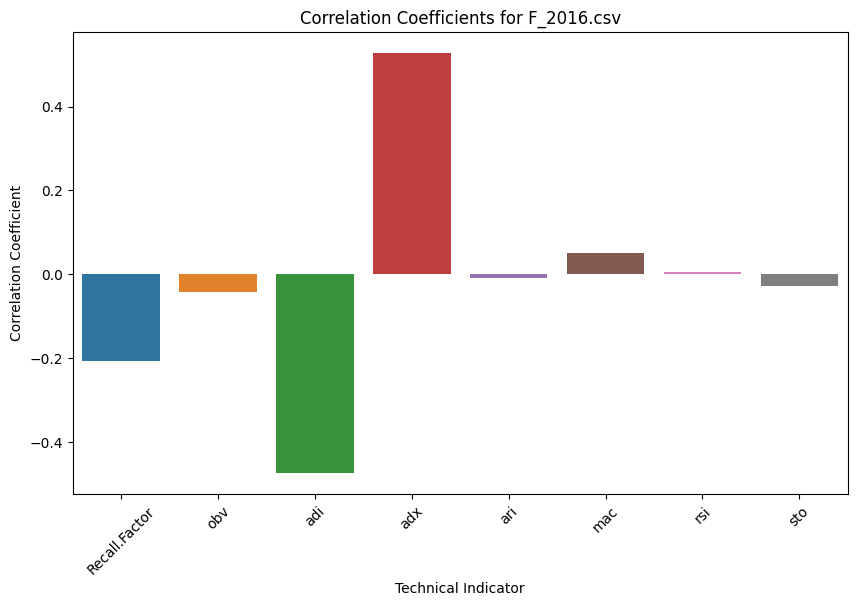

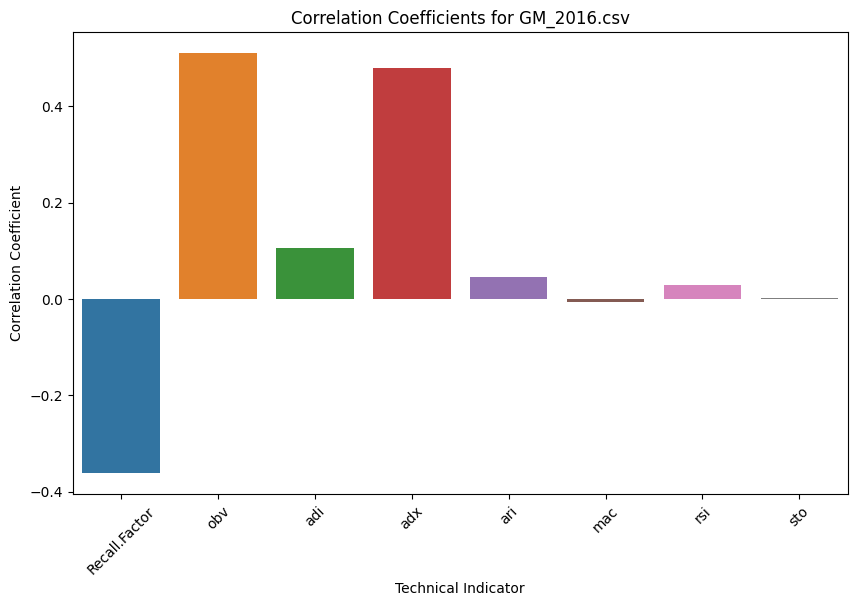

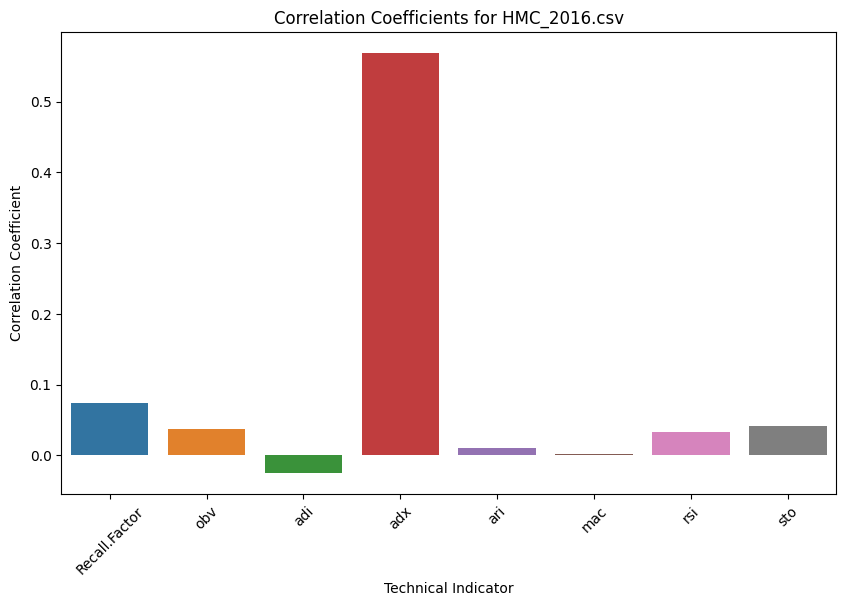

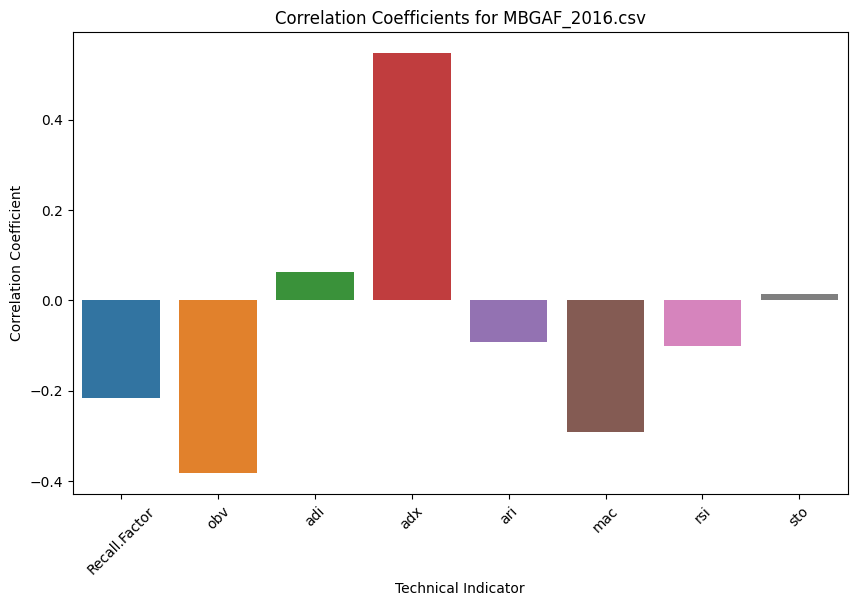

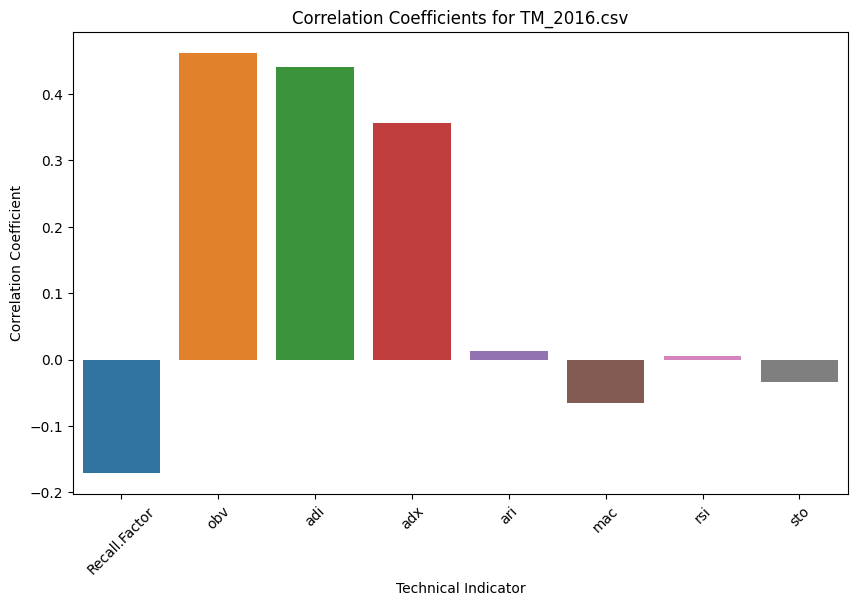

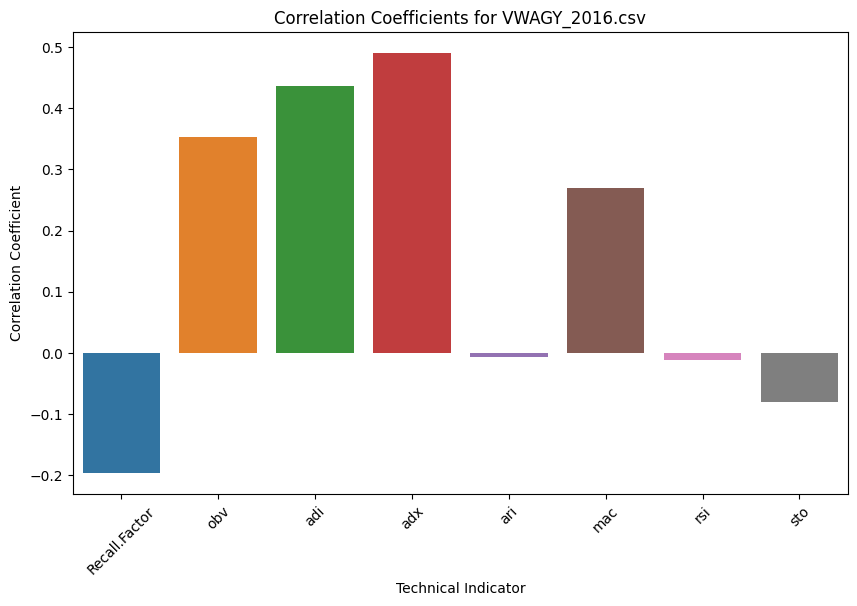

In [ ]:
### Technical Indicator and Volitity Correlation Analysis

# Correlation function
def correlation_calc(df, indicator):
  correlation_matrix = np.corrcoef(df[indicator], df['stdDev'])
  correlation = correlation_matrix[0, 1]
  return correlation

# To store correlation data
correlation_data = {}

# Loop through each stock and calculate correlation coefficients
for stock, df, in model_data.items():
  print(f"Correlation for {stock}:")
  technical_indicators = ['Recall.Factor', 'obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto']
  correlation_data[stock] = {}
  for indicator in technical_indicators:
    correlation_data[stock][indicator] = correlation_calc(df, indicator)
    print(f"Correlation between {indicator} and stock's standard deviation: {correlation_data[stock][indicator]:.3f}")
  print()

# Bar charts
for stock, data in correlation_data.items():
  df = pd.DataFrame(list(data.items()), columns=['Indicator', 'Correlation'])

  matplotlib.pyplot.figure(figsize=(10, 6))
  sns.barplot(x='Indicator', y='Correlation', data=df)
  matplotlib.pyplot.title(f'Correlation Coefficients for {stock}')
  matplotlib.pyplot.xticks(rotation=45)
  matplotlib.pyplot.xlabel('Technical Indicator')
  matplotlib.pyplot.ylabel('Correlation Coefficient')
  matplotlib.pyplot.show()

In [ ]:
### Consolidate correlation data for use in Tableau
consolidated_correlation_data = []

# Loop through each stock and append to list
for stock, indicators in correlation_data.items():
  for indicator, correlation in indicators.items():
    consolidated_correlation_data.append({
        'Stock': stock.replace('_2016.csv', ''),
        'Indicator': indicator,
        'Correlation': correlation
    })

correlation_df = pd.DataFrame(consolidated_correlation_data)

# Export to csv
correlation_df.to_csv('correlation_results.csv', index=False)

# Download csv
files.download('correlation_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### RANDOM FOREST MODEL
### training w/ recall indicator by default

for stock in stocks:

  df = model_data[stock]

  (df_train, df_test) = train_test_split(df, test_size=0.3, shuffle = False, random_state = 31337)

  ### train with recall factor
  x_train = df_train[['obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto', 'Recall.Factor']]
  x_test = df_test[['obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto', 'Recall.Factor']]

  ### uncomment to train without recall factor
  # x_train = df_train[['obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto']]
  # x_test = df_test[['obv', 'adi', 'adx', 'ari', 'mac', 'rsi', 'sto']]


  y_train = df_train[['next_close']]
  y_test = df_test[['next_close']]
  direction_labels_train = y_train['next_close'].shift(-1).ge(y_train['next_close'])
  direction_labels_test = y_test['next_close'].shift(-1).ge(y_test['next_close'])

  rf = RandomForestClassifier()

  param_grid = {'n_estimators': [15, 25, 35, 60, 100], 'max_depth': [3, 4, 5, 6, 7]}
  gscv_rfc = GridSearchCV(estimator = rf, param_grid = param_grid, error_score='raise')
  gscv_rfc.fit(x_train, direction_labels_train.values.flatten())

  best_params = gscv_rfc.best_params_

  rf_best = RandomForestClassifier(
      n_estimators = best_params['n_estimators'],
      max_depth = best_params['max_depth']
  )

  rf_best.fit(x_train, direction_labels_train.values.flatten())
  y_predict_train = rf_best.predict(x_train)
  y_predict_test = rf_best.predict(x_test)

  train_accuracy = accuracy_score(direction_labels_train, y_predict_train)
  test_accuracy = accuracy_score(direction_labels_test, y_predict_test)

  print("train accuracy: ", train_accuracy, " & test accuracy: ", test_accuracy)

  mse = mean_squared_error(y_test, y_predict_test)
  r2 = r2_score(y_test, y_predict_test)

  print(f"Stock: {stock}, MSE: {mse}, R2 Score: {r2}")

train accuracy:  0.6496290189612531  & test accuracy:  0.5115384615384615
Stock: F_2016.csv, MSE: 201.3498286486155, R2 Score: -19.432172336932474
train accuracy:  0.7279472382522671  & test accuracy:  0.5096153846153846
Stock: GM_2016.csv, MSE: 2346.363095042848, R2 Score: -24.312421768695497
train accuracy:  0.6207749381698269  & test accuracy:  0.4846153846153846
Stock: HMC_2016.csv, MSE: 789.4251384380774, R2 Score: -89.1588787085613
train accuracy:  0.761747732893652  & test accuracy:  0.5442307692307692
Stock: MBGAF_2016.csv, MSE: 5903.91633672762, R2 Score: -30.670398669010833
train accuracy:  0.686727122835944  & test accuracy:  0.5038461538461538
Stock: TM_2016.csv, MSE: 27222.382768665364, R2 Score: -89.20309124999552
train accuracy:  0.6273701566364386  & test accuracy:  0.5057692307692307
Stock: VWAGY_2016.csv, MSE: 700.85329295207, R2 Score: -15.24669472995945


# ARIMA

In [ ]:
#ARIMA
from statsmodels.tsa.arima.model import ARIMA
import math
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# DATA

df_F_sd = model_data['F_2016.csv']
df_F_sd = df_F_sd[['Date', 'stdDev']]
df_F_sd['Date'] = pd.to_datetime(df_F_sd['Date'])

df_GM_sd = model_data['GM_2016.csv']
df_GM_sd = df_GM_sd[['Date', 'stdDev']]
df_GM_sd['Date'] = pd.to_datetime(df_GM_sd['Date'])

df_HMC_sd = model_data['HMC_2016.csv']
df_HMC_sd = df_HMC_sd[['Date', 'stdDev']]
df_HMC_sd['Date'] = pd.to_datetime(df_HMC_sd['Date'])

df_MBGAF_sd = model_data['MBGAF_2016.csv']
df_MBGAF_sd = df_MBGAF_sd[['Date', 'stdDev']]
df_MBGAF_sd['Date'] = pd.to_datetime(df_MBGAF_sd['Date'])

df_TM_sd = model_data['TM_2016.csv']
df_TM_sd = df_TM_sd[['Date', 'stdDev']]
df_TM_sd['Date'] = pd.to_datetime(df_TM_sd['Date'])

df_VWAGY_sd = model_data['VWAGY_2016.csv']
df_VWAGY_sd = df_VWAGY_sd[['Date', 'stdDev']]
df_VWAGY_sd['Date'] = pd.to_datetime(df_VWAGY_sd['Date'])

In [ ]:
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from bokeh.plotting import figure, show, output_notebook
from statsmodels.tsa.arima_model import ARIMA


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00


In [ ]:
#Ford
auto_F = pm.auto_arima(df_F_sd.stdDev, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

display(auto_F.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7339.257, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3575.938, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1235.180, Time=0.62 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8305.074, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-8305.618, Time=1.34 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-8305.422, Time=0.83 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-8307.381, Time=1.36 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-8313.351, Time=2.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-8315.220, Time=1.84 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7841.102, Time=1.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-8313.523, Time=1.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-8086.548, Time=2.52 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-8064.800, Time=6.79 sec
 ARIMA(2,0,2)(0,0,0)[0] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:               SARIMAX(2, 0, 2)   Log Likelihood                4175.406
Date:                Thu, 30 Nov 2023   AIC                          -8338.812
Time:                        19:45:45   BIC                          -8306.066
Sample:                             0   HQIC                         -8326.701
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.001      3.803      0.000       0.002       0.006
ar.L1          1.8188      0.011    166.076      0.000       1.797       1.840
ar.L2         -0.8266      0.011    -76.550      0.000      -0.848      -0.805
ma.L1         -0.0208      0.016     -1.341      0.180      -0.051       0.010
ma.L2          0.0837      0.020      4.212      0.000       0.045       0.123
sigma2         0.0005      5e-06     94.232      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             49984.63
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               6.36   Skew:                             2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
next_30_F = auto_F.predict(n_periods=30)

df_F_sd_index = df_F_sd[['stdDev']]
next_30_F = next_30_F.to_frame()
next_30_F.rename(columns={next_30_F.columns[0]: "stdDev" }, inplace = True)

combine_F = pd.concat([df_F_sd_index , next_30_F])
combine_F



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,stdDev
29,0.675079
30,0.575722
31,0.482194
32,0.433605
33,0.425933
...,...
1758,0.731662
1759,0.720176
1760,0.709273
1761,0.698937


In [ ]:
#GM
auto_GM = pm.auto_arima(df_GM_sd.stdDev, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

display(auto_GM.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3933.430, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7303.296, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4740.239, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4740.396, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-4740.352, Time=0.84 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4738.553, Time=3.60 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4777.499, Time=2.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-4780.930, Time=0.46 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-4778.938, Time=3.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4780.760, Time=0.42 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 12.860 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:               SARIMAX(3, 0, 0)   Log Likelihood                2395.465
Date:                Thu, 30 Nov 2023   AIC                          -4780.930
Time:                        20:11:35   BIC                          -4753.642
Sample:                             0   HQIC                         -4770.838
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0187      0.004      4.990      0.000       0.011       0.026
ar.L1          1.7642      0.015    121.617      0.000       1.736       1.793
ar.L2         -0.7190      0.027    -26.864      0.000      -0.771      -0.667
ar.L3         -0.0560      0.014     -4.022      0.000      -0.083      -0.029
sigma2         0.0037   6.32e-05     58.131      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6606.79
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.51   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
next_30_GM = auto_GM.predict(n_periods=30)

df_GM_sd_index = df_GM_sd[['stdDev']]
next_30_GM = next_30_GM.to_frame()
next_30_GM.rename(columns={next_30_GM.columns[0]: "stdDev" }, inplace = True)

combine_GM = pd.concat([df_GM_sd_index , next_30_GM])
combine_GM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,stdDev
29,1.306939
30,1.091783
31,0.927299
32,0.849042
33,0.839603
...,...
1758,2.018095
1759,1.990041
1760,1.963870
1761,1.939546


In [ ]:
#HMC
auto_HMC = pm.auto_arima(df_HMC_sd.stdDev, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

display(auto_HMC.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6638.364, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4581.793, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2223.505, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7513.847, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7513.999, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-7513.901, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-7511.026, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7571.991, Time=0.78 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7578.237, Time=1.77 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7575.316, Time=4.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7578.054, Time=0.84 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 10.835 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3794.118
Date:                Thu, 30 Nov 2023   AIC                          -7578.237
Time:                        20:11:46   BIC                          -7550.949
Sample:                             0   HQIC                         -7568.144
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0129      0.002      7.827      0.000       0.010       0.016
ar.L1          1.7607      0.014    124.138      0.000       1.733       1.788
ar.L2         -0.7061      0.027    -25.905      0.000      -0.760      -0.653
ar.L3         -0.0701      0.015     -4.785      0.000      -0.099      -0.041
sigma2         0.0007   1.28e-05     57.121      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              4206.12
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
next_30_HMC = auto_HMC.predict(n_periods=30)

df_HMC_sd_index = df_HMC_sd[['stdDev']]
next_30_HMC = next_30_HMC.to_frame()
next_30_HMC.rename(columns={next_30_HMC.columns[0]: "stdDev" }, inplace = True)

combine_HMC = pd.concat([df_HMC_sd_index , next_30_HMC])
combine_HMC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,stdDev
29,1.761942
30,1.686370
31,1.607735
32,1.554485
33,1.522970
...,...
1758,0.857018
1759,0.856196
1760,0.855053
1761,0.853653


In [ ]:
#MBGAF
auto_MBGAF = pm.auto_arima(df_MBGAF_sd.stdDev, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

display(auto_MBGAF.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2271.457, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8781.966, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6437.181, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3214.456, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3216.422, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3214.461, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3216.725, Time=1.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-3220.857, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3219.485, Time=0.33 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-3219.339, Time=2.00 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-3220.201, Time=1.29 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3255.951, Time=6.99 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3268.943, Time=1.85 sec
 ARIMA(1,0,2)(0,0,0)[0] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1641.931
Date:                Thu, 30 Nov 2023   AIC                          -3271.863
Time:                        20:12:15   BIC                          -3239.117
Sample:                             0   HQIC                         -3259.752
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0582      0.010      5.622      0.000       0.038       0.078
ar.L1          1.1495      0.170      6.750      0.000       0.816       1.483
ar.L2          0.4080      0.309      1.319      0.187      -0.198       1.014
ar.L3         -0.5791      0.141     -4.112      0.000      -0.855      -0.303
ma.L1          0.6381      0.179      3.564      0.000       0.287       0.989
sigma2         0.0088   9.39e-05     93.771      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):             54230.61
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                             2.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
next_30_MBGAF = auto_MBGAF.predict(n_periods=30)

df_MBGAF_sd_index = df_MBGAF_sd[['stdDev']]
next_30_MBGAF = next_30_MBGAF.to_frame()
next_30_MBGAF.rename(columns={next_30_MBGAF.columns[0]: "stdDev" }, inplace = True)

combine_MBGAF = pd.concat([df_MBGAF_sd_index , next_30_MBGAF])
combine_MBGAF

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,stdDev
29,3.603697
30,3.175497
31,2.732988
32,2.467085
33,2.365007
...,...
1758,2.627173
1759,2.648516
1760,2.667169
1761,2.683305


In [ ]:
#TM
auto_TM = pm.auto_arima(df_TM_sd.stdDev, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

display(auto_TM.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1423.001, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9741.695, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2201.400, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-2202.485, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-2201.454, Time=0.69 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2199.856, Time=0.92 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2235.607, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-2236.853, Time=1.99 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-2234.899, Time=2.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2236.824, Time=3.11 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 12.075 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:               SARIMAX(3, 0, 0)   Log Likelihood                1123.426
Date:                Thu, 30 Nov 2023   AIC                          -2236.853
Time:                        20:12:27   BIC                          -2209.565
Sample:                             0   HQIC                         -2226.760
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0356      0.007      5.215      0.000       0.022       0.049
ar.L1          1.7653      0.012    147.999      0.000       1.742       1.789
ar.L2         -0.7324      0.024    -29.976      0.000      -0.780      -0.684
ar.L3         -0.0432      0.014     -3.094      0.002      -0.071      -0.016
sigma2         0.0159      0.000     72.455      0.000       0.016       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12753.52
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.07   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
next_30_TM = auto_TM.predict(n_periods=30)

df_TM_sd_index = df_TM_sd[['stdDev']]
next_30_TM = next_30_TM.to_frame()
next_30_TM.rename(columns={next_30_TM.columns[0]: "stdDev" }, inplace = True)

combine_TM = pd.concat([df_TM_sd_index , next_30_TM])
combine_TM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,stdDev
29,4.550185
30,4.436931
31,4.322954
32,4.420531
33,4.509387
...,...
1758,3.789896
1759,3.765465
1760,3.742367
1761,3.720595


In [ ]:
#VWAGY
auto_VWAGY = pm.auto_arima(df_VWAGY_sd.stdDev, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

display(auto_VWAGY.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5092.167, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5300.598, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5556.518, Time=1.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5522.580, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5558.102, Time=3.55 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-5545.426, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-5575.921, Time=3.56 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5563.244, Time=1.19 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-5588.363, Time=5.83 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-5588.495, Time=1.65 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-5402.841, Time=1.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5256.509, Time=0.87 sec
 ARIMA(2,0,3)(0,0,0)[0] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1733
Model:               SARIMAX(2, 0, 3)   Log Likelihood                2812.312
Date:                Thu, 30 Nov 2023   AIC                          -5610.625
Time:                        20:13:25   BIC                          -5572.421
Sample:                             0   HQIC                         -5596.495
                               - 1733                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0082      0.002      3.477      0.001       0.004       0.013
ar.L1          1.7942      0.018     98.576      0.000       1.758       1.830
ar.L2         -0.8036      0.018    -45.129      0.000      -0.838      -0.769
ma.L1         -0.1989      0.021     -9.474      0.000      -0.240      -0.158
ma.L2         -0.0808      0.015     -5.309      0.000      -0.111      -0.051
ma.L3          0.1441      0.021      6.791      0.000       0.103       0.186
sigma2         0.0023   1.12e-05    202.804      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           4677578.64
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              14.15   Skew:                             9.32
Prob(H) (two-sided):                  0.00   Kurtosis:                       256.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
next_30_VWAGY = auto_VWAGY.predict(n_periods=30)

df_VWAGY_sd_index = df_VWAGY_sd[['stdDev']]
next_30_VWAGY = next_30_VWAGY.to_frame()
next_30_VWAGY.rename(columns={next_30_VWAGY.columns[0]: "stdDev" }, inplace = True)

combine_VWAGY = pd.concat([df_VWAGY_sd_index , next_30_VWAGY])
combine_VWAGY

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,stdDev
29,0.590659
30,0.501036
31,0.483696
32,0.462214
33,0.463232
...,...
1758,1.113514
1759,1.098783
1760,1.084846
1761,1.071679


In [ ]:
# Function to add stock identifier and data type
def add_stock_info(combined_df, stock_name, historical_length):
    # Reset index to ensure it's unique and sequential
    combined_df.reset_index(drop=True, inplace=True)

    # Add stock identifier
    combined_df['Stock'] = stock_name

    # Add data type (Historical or Forecasted)
    combined_df['Type'] = ['Historical' if i < historical_length else 'Forecasted' for i in range(len(combined_df))]

    return combined_df

# Get length of historical data for each stock
len_F = len(df_F_sd)
len_GM = len(df_GM_sd)
len_HMC = len(df_HMC_sd)
len_MBGAF = len(df_MBGAF_sd)
len_TM = len(df_TM_sd)
len_VWAGY = len(df_VWAGY_sd)

# Add stock info
combine_F = add_stock_info(combine_F, 'Ford', len_F)
combine_GM = add_stock_info(combine_GM, 'GM', len_GM)
combine_HMC = add_stock_info(combine_HMC, 'HMC', len_HMC)
combine_MBGAF = add_stock_info(combine_MBGAF, 'MBGAF', len_MBGAF)
combine_TM = add_stock_info(combine_TM, 'TM', len_TM)
combine_VWAGY = add_stock_info(combine_VWAGY, 'VWAGY', len_VWAGY)

# Combine all into a single dataframe
all_stocks_combined = pd.concat([combine_F, combine_GM, combine_HMC, combine_MBGAF, combine_TM, combine_VWAGY])
# Display the final combined dataframe
print(all_stocks_combined)

# Save the dataframe to a CSV file for use in Tableau
all_stocks_combined.to_csv("stocks_arima_analysis.csv", index=True)


# Download csv
files.download("stocks_arima_analysis.csv")

        stdDev  Stock        Type
0     0.675079   Ford  Historical
1     0.575722   Ford  Historical
2     0.482194   Ford  Historical
3     0.433605   Ford  Historical
4     0.425933   Ford  Historical
...        ...    ...         ...
1758  1.113514  VWAGY  Forecasted
1759  1.098783  VWAGY  Forecasted
1760  1.084846  VWAGY  Forecasted
1761  1.071679  VWAGY  Forecasted
1762  1.059254  VWAGY  Forecasted

[10578 rows x 3 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
recalls = pd.read_csv('recall.csv')


     Report Received Date   NHTSA ID  \
0                 1/25/16  16V036000   
1                 1/28/16  16V046000   
2                 2/25/16  16V111000   
3                 2/25/16  16V110000   
4                 3/31/16  16V183000   
...                   ...        ...   
1362           02/11/2016  16V083000   
1363           02/10/2016  16V078000   
1364           02/10/2016  16V079000   
1365           01/28/2016  16V045000   
1366           01/25/2016  16V035000   

                                            Recall Link  \
0     Go to Recall (https://www.nhtsa.gov/recalls?nh...   
1     Go to Recall (https://www.nhtsa.gov/recalls?nh...   
2     Go to Recall (https://www.nhtsa.gov/recalls?nh...   
3     Go to Recall (https://www.nhtsa.gov/recalls?nh...   
4     Go to Recall (https://www.nhtsa.gov/recalls?nh...   
...                                                 ...   
1362  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
1363  Go to Recall (https://www.nhtsa.gov/recal